In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('telco_features.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_flag,tenure_bucket,num_services,avg_monthly_charge,is_month_to_month
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Yes,Electronic check,29.85,29.85,No,0,0-6,2,29.850000,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,Mailed check,56.95,1889.50,No,0,25-48,4,55.573529,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Yes,Mailed check,53.85,108.15,Yes,1,0-6,4,54.075000,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,Bank transfer (automatic),42.30,1840.75,No,0,25-48,4,40.905556,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Yes,Electronic check,70.70,151.65,Yes,1,0-6,2,75.825000,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7043 non-null   object 
 1   gender              7043 non-null   object 
 2   SeniorCitizen       7043 non-null   int64  
 3   Partner             7043 non-null   object 
 4   Dependents          7043 non-null   object 
 5   tenure              7043 non-null   int64  
 6   PhoneService        7043 non-null   object 
 7   MultipleLines       7043 non-null   object 
 8   InternetService     7043 non-null   object 
 9   OnlineSecurity      7043 non-null   object 
 10  OnlineBackup        7043 non-null   object 
 11  DeviceProtection    7043 non-null   object 
 12  TechSupport         7043 non-null   object 
 13  StreamingTV         7043 non-null   object 
 14  StreamingMovies     7043 non-null   object 
 15  Contract            7043 non-null   object 
 16  Paperl

## EXPLORATORY DATA ANALYSIS

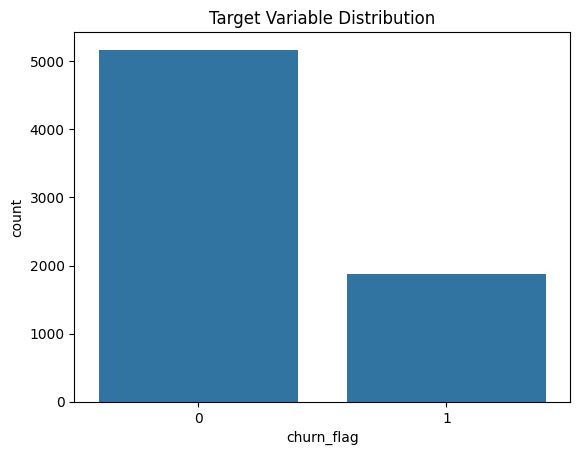

In [4]:
sns.countplot(x='churn_flag',data=df)
plt.title('Target Variable Distribution')
plt.show()

### Factors Indicating Commitment & Switching Cost
**1.Contract**

**2.Tenure**

**3.Partners & Dependents**

In [6]:
df.groupby('is_month_to_month')['churn_flag'].count()

is_month_to_month
0    3168
1    3875
Name: churn_flag, dtype: int64

In [7]:
df.groupby('is_month_to_month')['churn_flag'].mean()


is_month_to_month
0    0.067551
1    0.427097
Name: churn_flag, dtype: float64

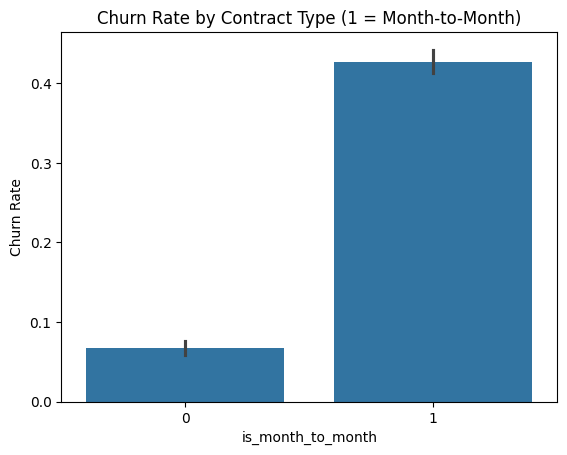

In [8]:
sns.barplot(
    x='is_month_to_month',
    y='churn_flag',
    data=df,
    estimator='mean'
)

plt.title('Churn Rate by Contract Type (1 = Month-to-Month)')
plt.ylabel('Churn Rate')
plt.show()

### Business Insight

**Customers on month-to-month contracts show significantly higher churn (42.7%) compared to annual contract customers (6.7%).**
**This suggests:**

-They have no commitment, so they switch easily.

-They may be more price-sensitive.

-They may have lower satisfaction with current service.

**Recommendation**

The company can reduce churn by:

-Offering discounts for upgrading to annual contracts

-Creating a loyalty program for month-to-month customers

-Prioritizing this group for retention campaigns

In [9]:
df.groupby('Contract')['churn_flag'].mean().sort_values()

Contract
Two year          0.028319
One year          0.112695
Month-to-month    0.427097
Name: churn_flag, dtype: float64

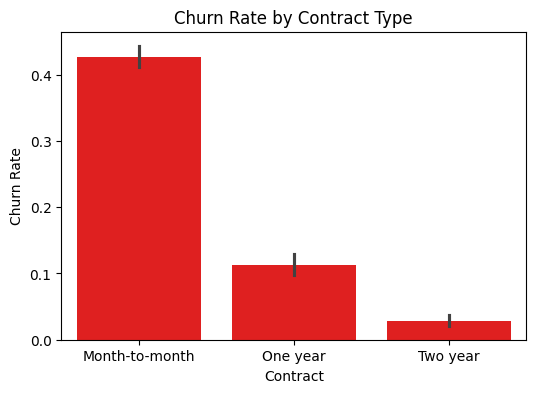

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='Contract',
    y='churn_flag',
    data=df,
    estimator='mean',
    color='Red'
)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()

**Two-year contracts: 2.8% churn**

**One-year contracts: 11.8% churn**

**Month-to-month: 42.7% churn**

**Month-to-month customers are the most unstable and churn the most.**

Business Recommendation

-Offer discounts for switching to 1–2 year contracts

-Provide loyalty incentives for month-to-month users

-Prioritize this segment for retention campaigns

In [30]:
tenure_sorted=df.groupby('tenure_bucket')['churn_flag'].mean().reset_index().sort_values('churn_flag')
tenure_sorted

,tenure_bucket,churn_flag
3,49+,0.095132
2,25-48,0.203890
1,13-24,0.287109
4,7-12,0.358865
0,0-6,0.529372


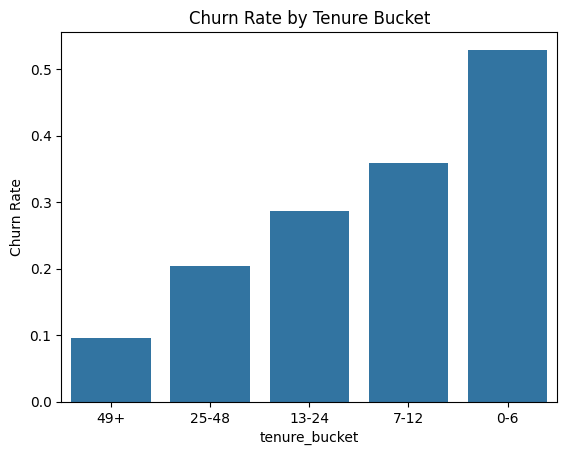

In [37]:
sns.barplot(
    data=tenure_sorted,
    x='tenure_bucket',
    y='churn_flag',
    errorbar=None
)
plt.title("Churn Rate by Tenure Bucket")
plt.ylabel("Churn Rate")
plt.show()

New customers (0–6 months) have the highest churn (often >50%).

Churn steadily increases as tenure decreases.

Long-term customers (49+ months) rarely churn (<5%).

**New customers are the most vulnerable group.**

Business Recommendation

-Improve first 90-day onboarding

-Give new customers discounts, welcome offers, or service walkthroughs

-Monitor early complaints and service requests closely

In [38]:
df.groupby('Dependents')['churn_flag'].mean()

Dependents
No     0.312791
Yes    0.154502
Name: churn_flag, dtype: float64

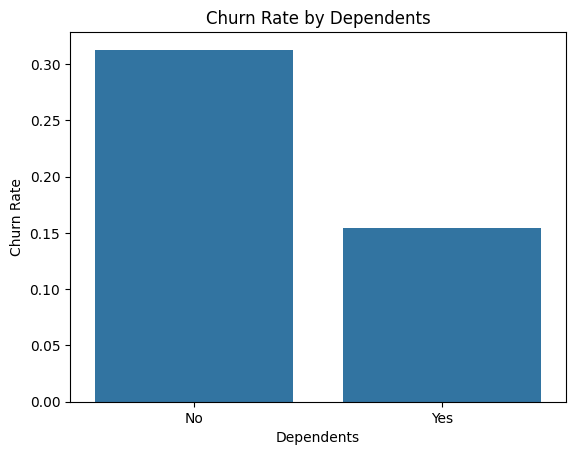

In [41]:
sns.barplot(
    x='Dependents',
    y='churn_flag',
    data=df,
    estimator='mean',
    ci=None
)
plt.title("Churn Rate by Dependents")
plt.ylabel("Churn Rate")
plt.show()

Customers with dependents churn less (15-16%)

Customers without dependents churn more (32-33%)

**People with dependents tend to be more stable and less price-sensitive.**

In [42]:
df.groupby('Partner')['churn_flag'].mean()

Partner
No     0.329580
Yes    0.196649
Name: churn_flag, dtype: float64

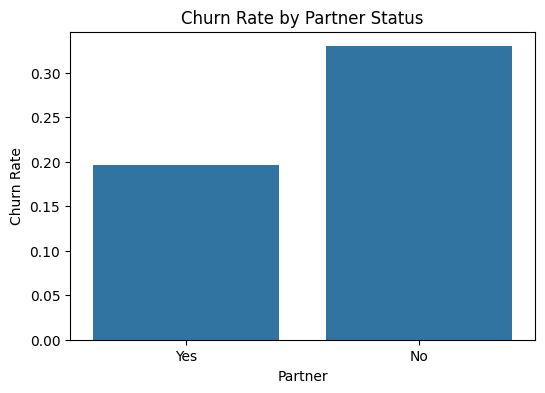

In [44]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='Partner',
    y='churn_flag',
    data=df,
    estimator='mean',
    errorbar=None
)
plt.title("Churn Rate by Partner Status")
plt.ylabel("Churn Rate")
plt.show()


Customers with partners churn much less (19%)

Customers without partners are almost 2× more likely to churn

**This suggests more stable households have stronger service retention.**

## After Analyzing Factors Indicating Commitment & Switching Cost 
### Summary:

-High churn groups:

-Month-to-month contract users

-Tenure below 12 months

-Customers without dependents/partners

**Retention Focus:**

-Encourage contract upgrades

-Improve onboarding during first 6 months

--Offer targeted benefits or discounts to single customers


## Factors including service quality and value
-Internet Service

-Tech Support, Online Security, Device Protection

-StreamingTv , StreamingMovies

In [45]:
df.groupby('num_services')['churn_flag'].mean()

num_services
1    0.092154
2    0.515818
3    0.434739
4    0.346782
5    0.272128
6    0.220073
7    0.125714
8    0.057915
Name: churn_flag, dtype: float64

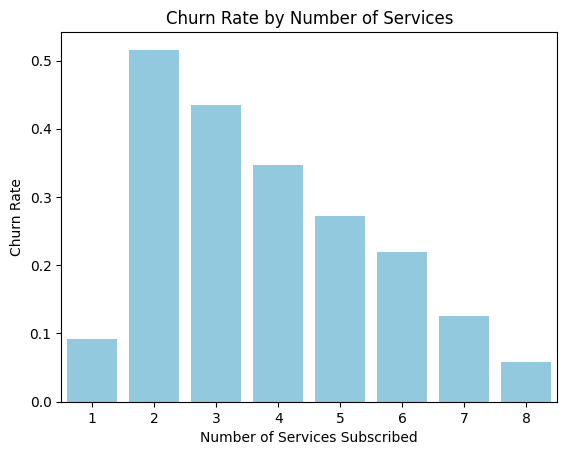

In [46]:
sns.barplot(
    x='num_services',
    y='churn_flag',
    data=df,
    errorbar=None,
    color='skyblue'
)
plt.title("Churn Rate by Number of Services")
plt.ylabel("Churn Rate")
plt.xlabel("Number of Services Subscribed")
plt.show()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7043 non-null   object 
 1   gender              7043 non-null   object 
 2   SeniorCitizen       7043 non-null   int64  
 3   Partner             7043 non-null   object 
 4   Dependents          7043 non-null   object 
 5   tenure              7043 non-null   int64  
 6   PhoneService        7043 non-null   object 
 7   MultipleLines       7043 non-null   object 
 8   InternetService     7043 non-null   object 
 9   OnlineSecurity      7043 non-null   object 
 10  OnlineBackup        7043 non-null   object 
 11  DeviceProtection    7043 non-null   object 
 12  TechSupport         7043 non-null   object 
 13  StreamingTV         7043 non-null   object 
 14  StreamingMovies     7043 non-null   object 
 15  Contract            7043 non-null   object 
 16  Paperl

In [53]:
df.groupby('InternetService')['churn_flag'].mean()

InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: churn_flag, dtype: float64

In [54]:
df.groupby('TechSupport')['churn_flag'].mean()

TechSupport
No                     0.416355
No internet service    0.074050
Yes                    0.151663
Name: churn_flag, dtype: float64

In [57]:
df.groupby('OnlineSecurity')['churn_flag'].mean()

OnlineSecurity
No                     0.417667
No internet service    0.074050
Yes                    0.146112
Name: churn_flag, dtype: float64

In [58]:
df.groupby('OnlineBackup')['churn_flag'].mean()

OnlineBackup
No                     0.399288
No internet service    0.074050
Yes                    0.215315
Name: churn_flag, dtype: float64

In [59]:
df.groupby('DeviceProtection')['churn_flag'].mean()

DeviceProtection
No                     0.391276
No internet service    0.074050
Yes                    0.225021
Name: churn_flag, dtype: float64

In [62]:
df.groupby('StreamingMovies')['churn_flag'].mean()

StreamingMovies
No                     0.336804
No internet service    0.074050
Yes                    0.299414
Name: churn_flag, dtype: float64

### Summary of Services EDA

**Critical features for reducing churn:**

-TechSupport, OnlineSecurity, OnlineBackup, DeviceProtection

**Secondary features:**

--StreamingMovies/TV

**Internet type matters:**

Fiber optic customers are higher risk

**Retention Strategy:**

Upsell protective services for high-risk customers (Fiber optic + month-to-month + low tenure)

Bundle services to increase stickiness

## Factors Indicating Financial Health & Friction
-Monthly Charges & Total Charges

-Paperless Billing

-Payment Method

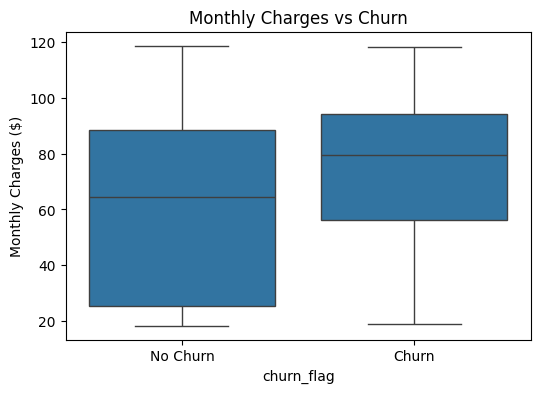

In [66]:
plt.figure(figsize=(6,4))
sns.boxplot(x='churn_flag', y='MonthlyCharges', data=df)
plt.xticks([0,1], ['No Churn','Churn'])
plt.title("Monthly Charges vs Churn")
plt.ylabel("Monthly Charges ($)")
plt.show()


-Customers who churn tend to have slightly higher monthly charges.

-High-value customers may be more sensitive to price, especially on month-to-month contracts.

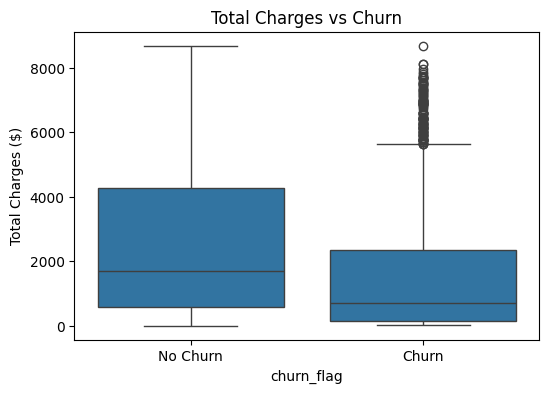

In [67]:
plt.figure(figsize=(6,4))
sns.boxplot(x='churn_flag', y='TotalCharges', data=df)
plt.xticks([0,1], ['No Churn','Churn'])
plt.title("Total Charges vs Churn")
plt.ylabel("Total Charges ($)")
plt.show()


-Customers with low total charges are often newer, thus more likely to churn.

-Long-term customers with high total charges tend to stay.

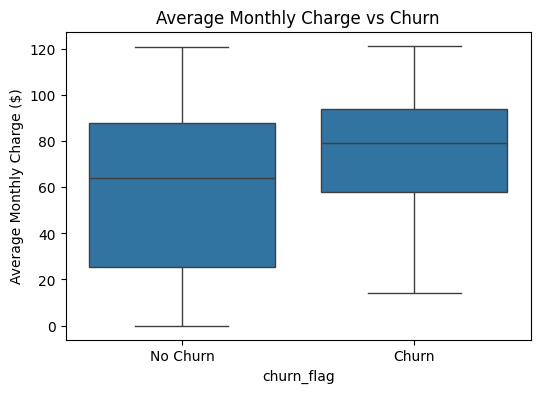

In [69]:
plt.figure(figsize=(6,4))
sns.boxplot(x='churn_flag', y='avg_monthly_charge', data=df)
plt.xticks([0,1], ['No Churn','Churn'])
plt.title("Average Monthly Charge vs Churn")
plt.ylabel("Average Monthly Charge ($)")
plt.show()


-Confirms that high average monthly charge customers have higher churn.

-Useful for segmenting retention strategies.

**As both number of services and monthly charges seems like a good predictor, let's check their combined impact**

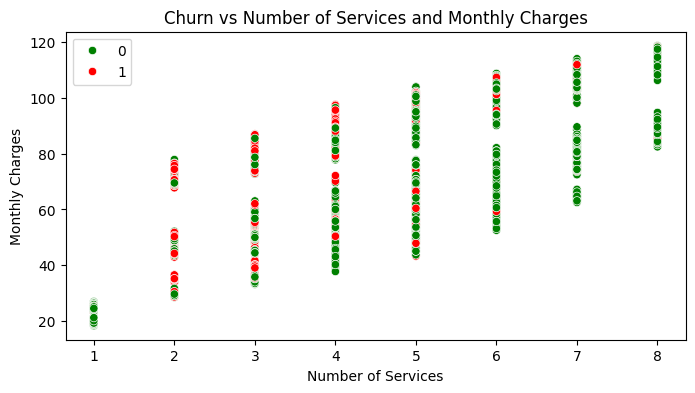

In [65]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    x='num_services',
    y='MonthlyCharges',
    hue='churn_flag',
    data=df,
    palette={0:'green',1:'red'}
)
plt.title("Churn vs Number of Services and Monthly Charges")
plt.xlabel("Number of Services")
plt.ylabel("Monthly Charges")
plt.legend()
plt.show()